In [15]:
import uproot
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplhep

In [16]:
CONFIG_FILE = '/home/diptaparna/Documents/CaloML/config_hgm_mc16.yaml'
ONNX_MODEL_PATH = '/home/diptaparna/Documents/CaloML/HGM_3.model-03-12-2025.onnx'
INPUT_NTUPLE = '/home/diptaparna/Documents/CaloML/ClusterEnergies.root'

In [17]:
df = uproot.concatenate(INPUT_NTUPLE, library='pd')

In [18]:
df.head()

clusterE  clusterE_LCW  clusterE_Truth  clusterEta  cluster_SIGNIFICANCE  \
0  16.499309     22.967885    16166.611328    1.874702             82.801994   
1   9.138374     13.189838     7197.510254    1.788090             20.072351   
2   2.748852      4.042329     2678.146729    0.399391              9.035995   
3   3.375970      6.719827     2839.731201    1.105703             11.350155   
4   2.404664      4.596327     2574.151123    1.009612              8.215182   

   cluster_time  cluster_SECOND_TIME  cluster_CENTER_LAMBDA  \
0      0.102387             0.046077             256.037323   
1      0.133287             0.781234             102.551758   
2      1.206650             0.331080            1005.168762   
3      0.203049            19.057089             312.104462   
4      3.097960            30.369579             284.807587   

   cluster_CENTER_MAG  cluster_ENG_FRAC_EM  cluster_FIRST_ENG_DENS  \
0         4177.289551             1.000000                0.020791   
1         4066.940918             0.846218                0.007591   
2         2623.692383             0.058387                0.000053   
3         2783.903320             0.920799                0.000500   
4         2590.650879             1.000000                0.000565   

   cluster_LONGITUDINAL  cluster_LATERAL  cluster_PTD  cluster_ISOLATION  \
0              0.244089         0.399780     0.635285           0.880452   
1              0.798493         0.785001     0.244286           0.951204   
2              0.739138         0.543075     0.555546           0.835458   
3              0.834718         0.816080     0.334258           0.746926   
4              0.812865         0.715392     0.345916           1.000000   

   nPrimVtx  avgMu  
0         3    0.0  
1         3    0.0  
2         3    0.0  
3         3    0.0  
4         3    0.0

In [19]:
from process_features import FeatureProcessor

In [20]:
processor = FeatureProcessor(config_path=CONFIG_FILE)
df_scaled = processor.transform(df)
model_outputs = processor.run_inference(model_path=ONNX_MODEL_PATH, df=df_scaled)

FeatureProcessor initialized successfully.

Applying transformations to 13565 rows...
  - Processing column 'clusterE'...
    - Applied 'LogTenStandard' successfully.
  - Processing column 'clusterEta'...
    - Applied 'Standard' successfully.
  - Processing column 'cluster_SIGNIFICANCE'...
    - Applied 'LogTenStandard' successfully.
  - Processing column 'cluster_time'...
    - Applied 'MaxAbsolute' successfully.
  - Processing column 'cluster_SECOND_TIME'...
    - Applied 'LogTenStandard' successfully.
  - Processing column 'cluster_CENTER_LAMBDA'...
    - Applied 'LogTenStandard' successfully.
  - Processing column 'cluster_CENTER_MAG'...
    - Applied 'Standard' successfully.
  - Processing column 'cluster_ENG_FRAC_EM'...
    - Applied 'Standard' successfully.
  - Processing column 'cluster_FIRST_ENG_DENS'...
    - Applied 'LogTenStandard' successfully.
  - Processing column 'cluster_LONGITUDINAL'...
    - Applied 'Standard' successfully.
  - Processing column 'cluster_LATERAL'...

/home/diptaparna/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [21]:
import scipy

def log_likelihood(x, mus, log_sigma2s, alphas):
    """
    Logarithm of the probability density of a Gaussian mixture distribution (log-likelihood).
    This construction uses the log-sum-exp method from PyTorch which is numerically
    more stable then just computing: log(prob) = log(sum_i alpha_i*Gauss(mu_i, sigma_i))
    """

    # calculate one-dimensional negative log-Gaussians
    # neg_log_gauss = -log(Gauss(mu_i, sigma_i))
    # neg_log_gauss : shape = (num_monte, batch_size, x_sample, 3)
    neg_log_gauss  = np.pow(mus-x, 2.0)/(2.0*np.exp(log_sigma2s)) + 0.5*log_sigma2s
    neg_log_gauss += 0.5*np.log(2.0*np.pi) # constant

    # log_prob_components = -neg_log_gauss_i + log(alpha_i)
    #                     = log(Gauss(mu_i, sigma_i)) + log(alpha_i)
    # log_prob_components : shape = (num_monte, batch_size, x_sample, 3)
    log_likelihood_components = -neg_log_gauss + np.log(alphas)
    
    # log_prob = log(sum_i exp(log_prob_components_i))
    #          = log(sum_i exp(log(Gauss(mu_i, sigma_i)) + log(alpha_i)))
    # log_prob : shape = (num_monte, batch_size, x_sample)
    log_likelihood = scipy.special.logsumexp(log_likelihood_components, axis=-1)

    return log_likelihood


def modes(mus, sigma2s, alphas):
    # select range to check for maxima
    x_min = 0.9*np.min(mus, axis=-1)
    x_max = 1.1*np.max(mus, axis=-1)
    
    # create array of ranges to check for maxima
    x_test = np.linspace(x_min, x_max, num=1000)
    # x_test  : shape = (x_sample, batch_size)
    # mus     : shape = (batch_size, num_mixtures)
    # sigma2s : shape = (batch_size, num_mixtures)
    # alphas  : shape = (batch_size, num_mixtures)

    # reshape parameters for likelihood computations
    x_test_reshaped  = np.transpose(x_test,  axes=(1, 0))[:,:,None]
    mus_reshaped     = np.transpose(mus,     axes=(0, 1))[:,None,:]
    sigma2s_reshaped = np.transpose(sigma2s, axes=(0, 1))[:,None,:]
    alphas_reshaped  = np.transpose(alphas,  axes=(0, 1))[:,None,:]

    # compute negative log-likelihood (NLL)
    neg_log_likelihood = -log_likelihood(x_test_reshaped, mus_reshaped, np.log(sigma2s_reshaped), alphas_reshaped)

    # choose x-point with largest likelihood value (= smallest NLL value)
    idxs  = np.argmin(neg_log_likelihood, axis=-1, keepdims=True)
    modes = np.take_along_axis(np.squeeze(x_test_reshaped, axis=-1), idxs, axis=-1)

    # shape = (batch_size)
    predictions = np.squeeze(modes, axis=-1)

    return predictions


mus, log_sigma2s, alphas = model_outputs
sigma2s = np.exp(log_sigma2s)
predictions = modes(10**mus, sigma2s, alphas)

df['clusterE_ML'] = predictions
df['clusterE_mu_0'] = 10**mus[:,0]
df['clusterE_mu_1'] = 10**mus[:,1]
df['clusterE_mu_2'] = 10**mus[:,2]

In [22]:
df.head(10)

clusterE  clusterE_LCW  clusterE_Truth  clusterEta  cluster_SIGNIFICANCE  \
0  16.499309     22.967885    16166.611328    1.874702             82.801994   
1   9.138374     13.189838     7197.510254    1.788090             20.072351   
2   2.748852      4.042329     2678.146729    0.399391              9.035995   
3   3.375970      6.719827     2839.731201    1.105703             11.350155   
4   2.404664      4.596327     2574.151123    1.009612              8.215182   
5   2.944845      6.251516     2618.383057    1.351318              8.973540   
6   2.415144      4.553989     2612.618896    1.194675              9.981880   
7   1.902052      4.237539     2065.951172    1.074963             20.680780   
8   0.951745      1.738884      358.795349    0.349502              7.550046   
9   4.825946      9.085879     4195.922363    2.391989              7.860157   

   cluster_time  cluster_SECOND_TIME  cluster_CENTER_LAMBDA  \
0      0.102387             0.046077             256.037323   
1      0.133287             0.781234             102.551758   
2      1.206650             0.331080            1005.168762   
3      0.203049            19.057089             312.104462   
4      3.097960            30.369579             284.807587   
5      0.914806             0.355119            1994.506958   
6      1.917722            38.968178             353.429199   
7      1.809026             4.442522             609.212891   
8      2.384143             0.000000            1004.349976   
9     -0.189097             0.123906             132.496979   

   cluster_CENTER_MAG  cluster_ENG_FRAC_EM  ...  cluster_LONGITUDINAL  \
0         4177.289551             1.000000  ...              0.244089   
1         4066.940918             0.846218  ...              0.798493   
2         2623.692383             0.058387  ...              0.739138   
3         2783.903320             0.920799  ...              0.834718   
4         2590.650879             1.000000  ...              0.812865   
5         5082.816406             0.007329  ...              0.751113   
6         3039.853271             0.973441  ...              0.895027   
7         3024.998779             1.000000  ...              0.733040   
8         2606.141357             0.014371  ...              0.563939   
9         3944.816406             1.000000  ...              0.444755   

   cluster_LATERAL  cluster_PTD  cluster_ISOLATION  nPrimVtx  avgMu  \
0         0.399780     0.635285           0.880452         3    0.0   
1         0.785001     0.244286           0.951204         3    0.0   
2         0.543075     0.555546           0.835458         3    0.0   
3         0.816080     0.334258           0.746926         3    0.0   
4         0.715392     0.345916           1.000000         3    0.0   
5         0.648420     0.731039           1.000000         3    0.0   
6         0.803622     0.378793           1.000000         3    0.0   
7         0.748048     0.496485           0.863556         3    0.0   
8         0.031539     0.936088           0.717568         3    0.0   
9         0.312210     0.360474           1.000000         3    0.0   

   clusterE_ML  clusterE_mu_0  clusterE_mu_1  clusterE_mu_2  
0     1.656580       2.816226       1.657825       4.535771  
1     2.928990       6.030156       2.926821       8.770356  
2    13.468621      11.550236       5.622105      13.469419  
3     1.538067       2.712783       1.538912       3.087977  
4     1.293353       2.362661       1.293431       2.061866  
5    11.872562       9.548821       4.492215      11.876916  
6     1.476977       2.771481       1.476594       2.463537  
7     1.405000       2.232988       1.404658       1.907373  
8     3.769184       3.768443       2.667927       4.895597  
9     1.641425       4.595974       1.640941       4.818561  

[10 rows x 21 columns]

In [23]:
mplhep.style.use('ATLAS')

(exptext: Custom Text(0.05, 0.95, 'ATLAS'),
 expsuffix: Custom Text(0.05, 0.955, 'Simulation Preliminary'),
 supptext: Custom Text(0.05, 0.95, ''),
 expsuffix: Custom Text(0.05, 0.95, '$\\sqrt{s} = \\mathrm{13\\ TeV}$'))

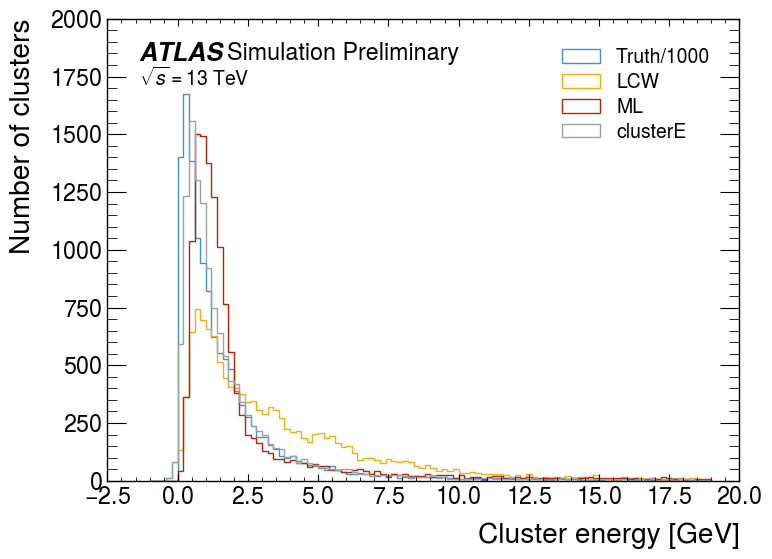

In [24]:
fig, ax = plt.subplots()
ax.hist(df['clusterE_Truth']/1000, range=(-1,19), bins=100, histtype='step', label='Truth/1000')
ax.hist(df['clusterE_LCW'], range=(-1,19), bins=100, histtype='step', label='LCW')
ax.hist(df['clusterE_ML'], range=(-1,19), bins=100, histtype='step', label='ML')
ax.hist(df['clusterE'], range=(-1,19), bins=100, histtype='step', label='clusterE')
ax.legend()
ax.set_ylim(0, 2000)
ax.set_xlabel('Cluster energy [GeV]')
ax.set_ylabel('Number of clusters')
mplhep.atlas.label('Preliminary', data=False, ax=ax)

In [25]:
mus = np.array([
    [5.0, 15.0, 10.0],
    [2.0, 8.0, 20.0]
])
sigma2s = np.array([
    [1.5, 1.0, 5.0],
    [2.0, 3.0, 0.5]
])
alphas = np.array([
    [0.45, 0.45, 0.1],
    [0.1, 0.2, 0.7]
])

In [26]:
modes(mus, sigma2s, alphas)

array([14.98648649, 19.9981982 ])

In [27]:
from model import modes as modes_pytorch
import torch

In [28]:
modes_pytorch(torch.from_numpy(mus), torch.from_numpy(sigma2s), torch.from_numpy(alphas))

tensor([14.9865, 19.9982], dtype=torch.float64)

In [29]:
! ./cpp/main

--- Test Case 1 ---
mus: {5.0, 15.0, 10.0}
sigma2s: {1.5, 1.0, 5.0}
alphas: {0.45, 0.45, 0.1}
Predicted mode: 14.9865

--- Test Case 2 ---
mus: {2.0, 8.0, 20.0}
sigma2s: {2.0, 3.0, 0.5}
alphas: {0.1, 0.2, 0.7}
Predicted Mode: 19.9982
